# 📚 Saluda: Cognitive Fingerprinting for Book Conversations
## Building an AI Companion from Reading Memories

**Collaborators:** Amy Zhang, Claude AI, ChatGPT, Perplexity

**Project Goal:** Transform spontaneous book reactions into an AI companion that connects current emotions/thoughts to past reading experiences.

---

### Status: 2025-10-04

This notebook demonstrates the **core proof-of-concept** for Saluda — an AI that remembers your book reactions and uses them for emotional support:

1. **📊 Embedding & Chunking Pipeline**  
   Convert manual book spelunking transcripts into searchable memory chunks.

2. **🗺️ Cognitive Landscape Visualization**  
   Map how different books cluster in your reading consciousness.

3. **💬 Conversational AI Interface**  
   Saluda responds to emotions by drawing on relevant reading memories.

4. **🔍 Meta-Reasoning Analysis**  
   Examine how Saluda thinks about making emotional connections.

---

### 🎯 Real-World Test: Addressing Today's AI Anxieties ⚠️

We deliberately tested Saluda on the **two biggest fears people have about AI right now**:

**"The job market sucks right now"** *(AI displacement anxiety)*  
- Everyone's worried AI will take their jobs  
- #1 concern in public AI discourse  
- People feel powerless against technological change  

**"My parents won't listen to me"** *(AI safety/youth concerns)*  
- Parents struggling with kids navigating AI (deepfakes, misinformation, etc.)  
- Generational divide on AI understanding  
- **Young people lacking proper AI guidance/guardrails**

**The Goal:** AI could address the biggest fears about AI itself in a deeply personalized, thoughtful way. AI collaborators don't have to be part of the problem (disconnected, generic responses); perhaps they can help people process modern anxieties through their own authentic intellectual/emotional patterns.


In [10]:
# ======================================
# 0. Setup
# ======================================
# Install sentence-transformers if not already installed
!pip install -q sentence-transformers

# ======================================
# 1. Import Libraries
# ======================================
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import json
from typing import List, Dict

# ======================================
# 2. Load and Combine CSVs
# ======================================
csv_files = [
    'Risk.csv',
    'MinorFeelings.csv',
    'ReturnOfNative.csv'
]

# Read CSVs into DataFrames
dfs = [pd.read_csv(f) for f in csv_files]

# Fill missing values for author and book_title
for df in dfs:
    df['author'] = df['author'].fillna('Unknown')
    df['book_title'] = df['book_title'].fillna('Unknown')

# Combine all CSVs into one DataFrame
df = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(df)} rows from {len(csv_files)} files")
df.head()


Loaded 54 rows from 3 files


,book_title,author,edition,page,type,text,start_time,end_time
0,"against the gods, the remarkable story of risk.",peter l. bernstein,NaN,1,passage,The revolutionary idea that defines the bound...,53.96,173.76
1,"against the gods, the remarkable story of risk.",peter l. bernstein,NaN,1,reaction,"Saluda, I like the clarity of the writing here...",NaN,NaN
2,"against the gods, the remarkable story of risk.",peter l. bernstein,NaN,1,passage,This book tells the story of a group of think...,193.60,233.94
3,"against the gods, the remarkable story of risk.",peter l. bernstein,NaN,1,reaction,"Saluda, I can almost hear the trumpet fanfare ...",240.60,386.24
4,"against the gods, the remarkable story of risk.",peter l. bernstein,NaN,2,passage,"Given all its problems and pitfalls, the free...",404.20,440.32


In [6]:
# ======================================
# 3. Define the Embedder Class
# ======================================
class BookSpelunkingEmbedder:
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        """Initialize with a lightweight sentence transformer model"""
        self.model = SentenceTransformer(model_name)
        self.chunks = []
        self.embeddings = None
        self.metadata = []

    def create_passage_reaction_chunks(self, df: pd.DataFrame) -> List[Dict]:
        """Create chunks by pairing passages with their reactions"""
        chunks = []

        for book_title in df['book_title'].unique():
            book_data = df[df['book_title'] == book_title].copy()
            author = book_data['author'].iloc[0]
            book_data = book_data.sort_values(['page', 'start_time'], na_position='last')

            i = 0
            while i < len(book_data):
                current_row = book_data.iloc[i]

                if current_row['type'] == 'passage':
                    if (i + 1 < len(book_data) and
                        book_data.iloc[i + 1]['type'] == 'reaction' and
                        book_data.iloc[i + 1]['page'] == current_row['page']):

                        reaction_row = book_data.iloc[i + 1]
                        chunk_text = self._format_passage_reaction_chunk(
                            book_title, author, current_row['page'],
                            current_row['text'], reaction_row['text']
                        )

                        chunks.append({
                            'text': chunk_text,
                            'book_title': book_title,
                            'author': author,
                            'page': current_row['page'],
                            'chunk_type': 'passage_reaction_pair',
                            'passage_text': current_row['text'],
                            'reaction_text': reaction_row['text']
                        })
                        i += 2
                    else:
                        chunk_text = self._format_standalone_chunk(
                            book_title, author, current_row['page'],
                            'passage', current_row['text']
                        )
                        chunks.append({
                            'text': chunk_text,
                            'book_title': book_title,
                            'author': author,
                            'page': current_row['page'],
                            'chunk_type': 'standalone_passage',
                            'content': current_row['text']
                        })
                        i += 1

                elif current_row['type'] == 'reaction':
                    chunk_text = self._format_standalone_chunk(
                        book_title, author, current_row['page'],
                        'reaction', current_row['text']
                    )
                    chunks.append({
                        'text': chunk_text,
                        'book_title': book_title,
                        'author': author,
                        'page': current_row['page'],
                        'chunk_type': 'standalone_reaction',
                        'content': current_row['text']
                    })
                    i += 1
                else:
                    i += 1

        return chunks

    def _format_passage_reaction_chunk(self, book_title, author, page, passage, reaction):
        return f"""Book: {book_title} by {author}
Page: {page}


Passage: "{passage.strip()}"


My reaction: {reaction.strip()}"""

    def _format_standalone_chunk(self, book_title, author, page, content_type, content):
        type_label = "Passage" if content_type == "passage" else "My reaction"
        content_text = f'"{content.strip()}"' if content_type == "passage" else content.strip()
        return f"""Book: {book_title} by {author}
Page: {page}


{type_label}: {content_text}"""

    def embed_chunks(self, chunks: List[Dict]) -> np.ndarray:
        texts = [chunk['text'] for chunk in chunks]
        embeddings = self.model.encode(texts, show_progress_bar=True)
        self.chunks = chunks
        self.embeddings = embeddings
        self.metadata = [{k: v for k, v in chunk.items() if k != 'text'} for chunk in chunks]
        return embeddings

    def save_embeddings(self, save_path: str):
        save_data = {
            'chunks': self.chunks,
            'embeddings': self.embeddings.tolist(),
            'metadata': self.metadata,
            'model_name': self.model.get_sentence_embedding_dimension()
        }

        # Convert all numpy.int64 or numpy.float64 to native Python types
        def convert_numpy(o):
            if isinstance(o, (np.integer, np.int64)):
                return int(o)
            elif isinstance(o, (np.floating, np.float64)):
                return float(o)
            else:
                return o

        with open(save_path, 'w') as f:
            json.dump(save_data, f, default=convert_numpy, indent=2)

        print(f"Saved {len(self.chunks)} chunks to {save_path}")

    def preview_chunks(self, n: int = 3):
        for i, chunk in enumerate(self.chunks[:n]):
            print(f"=== CHUNK {i+1} ===")
            print(chunk['text'])
            print(f"Type: {chunk['chunk_type']}\n")


In [7]:
# ======================================
# 4. Run the Workflow
# ======================================
# Initialize the embedder
embedder = BookSpelunkingEmbedder()

# Create chunks
chunks = embedder.create_passage_reaction_chunks(df)
embedder.chunks = chunks
print(f"Created {len(chunks)} chunks")

# Preview first 3 chunks
embedder.preview_chunks(3)

# Generate embeddings
embeddings = embedder.embed_chunks(chunks)
print(f"Generated embeddings with shape: {embeddings.shape}")

# Save to JSON
embedder.save_embeddings('book_spelunking_embeddings.json')


Created 31 chunks
=== CHUNK 1 ===
Book: against the gods, the remarkable story of risk. by peter l. bernstein
Page: 1


Passage: "The revolutionary idea that defines the boundary between modern times and the past is the  mastery of risk.  The notion that the future is more than a whim of the gods and that men and women are  not passive before nature.  until human beings discovered away across that boundary, the future was a mirror of the past or the murky domain of oracles and soothsayers who held the monopoly over knowledge of anticipated events.  I like the clarity of the writing here and the boldness of the assertion.  Speaking about all of humanity's past attitude seems like a really daring thing to do.  It's a generalization, but it feels on point. I don't know. I guess it's like informal logic.  One of those postulates that can be taken as an axiom. That's the word I'm looking for.  Something axiomatic.  Also, I feel very much  I'm tired still and some of that thinking I for sure

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (31, 384)
Saved 31 chunks to book_spelunking_embeddings.json


Loaded 31 reading memories
Books: ['The Return of the Native', 'minor feelings, an Asian American reckoning.', 'against the gods, the remarkable story of risk.', 'Unknown']
Reducing embeddings to 2D... (this might take a moment)

=== Quick Insights ===
📚 Total reading memories: 31
📖 Books analyzed: 4
🎯 Most 'central' reading memory:
   Book: Unknown
   Type: passage_reaction_pair
   Text preview: Book: Unknown by Unknown
Page: 257


Passage: "This man from Paris was now so disguised by his leath...


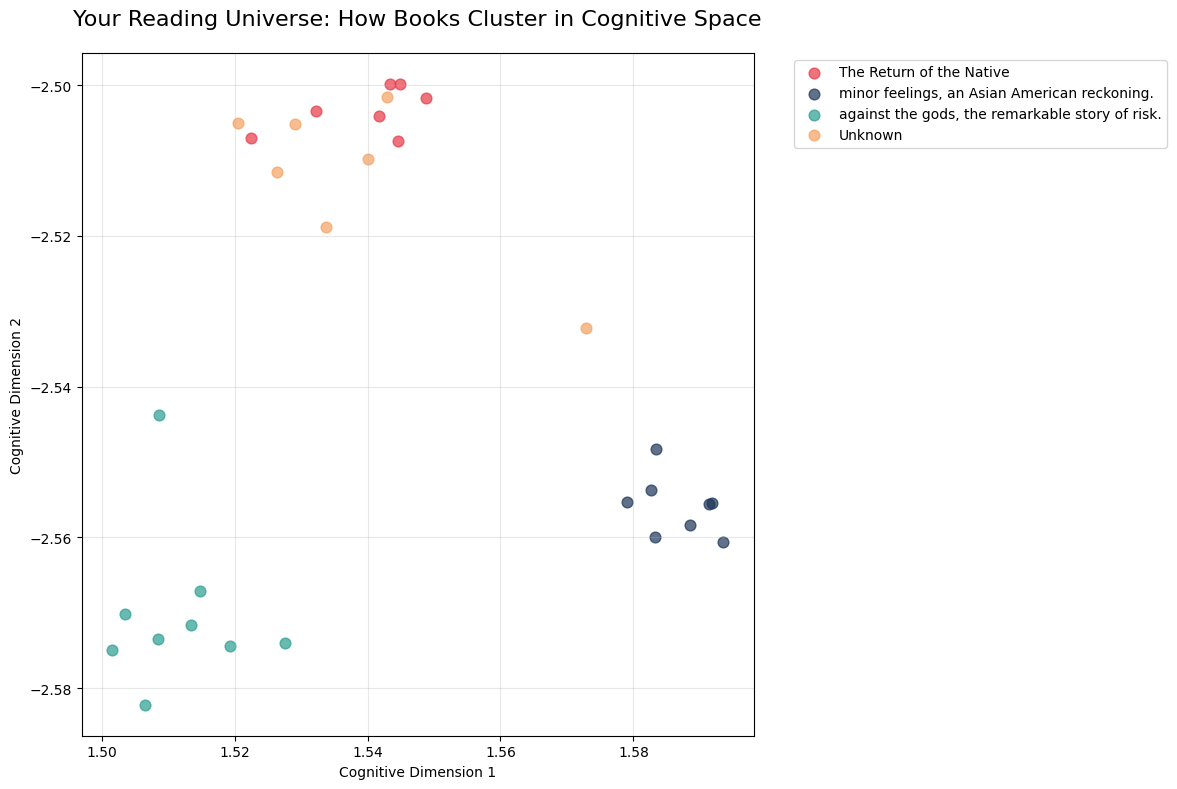


=== How Similar Are Your Books? ===
📏 The Return of the Native ↔ minor feelings, an Asian American reckoning.: 0.07
📏 The Return of the Native ↔ against the gods, the remarkable story of risk.: 0.07
📏 The Return of the Native ↔ Unknown: 0.01
📏 minor feelings, an Asian American reckoning. ↔ against the gods, the remarkable story of risk.: 0.08
📏 minor feelings, an Asian American reckoning. ↔ Unknown: 0.07
📏 against the gods, the remarkable story of risk. ↔ Unknown: 0.06


In [9]:
# Quick visualization of your reading embeddings in 2D space
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Load your embeddings
with open('book_spelunking_embeddings.json', 'r') as f:
    data = json.load(f)

embeddings = np.array(data['embeddings'])
chunks = data['chunks']
metadata = data['metadata']

print(f"Loaded {len(embeddings)} reading memories")

# Extract book titles for coloring
book_titles = [meta['book_title'] for meta in metadata]
unique_books = list(set(book_titles))
print(f"Books: {unique_books}")

colors = [
    '#E63946',  # red
    '#1D3557',  # dark blue
    '#2A9D8F',  # teal/green
    '#F4A261',  # orange
    '#264653',  # deep navy
    '#F94144',  # bright red
    '#577590',  # muted blue
]

book_colors = {book: colors[i % len(colors)] for i, book in enumerate(unique_books)}

# Reduce to 2D using t-SNE
print("Reducing embeddings to 2D... (this might take a moment)")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
embeddings_2d = tsne.fit_transform(embeddings)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each book with different colors
for book in unique_books:
    book_indices = [i for i, title in enumerate(book_titles) if title == book]
    book_embeddings = embeddings_2d[book_indices]

    plt.scatter(
        book_embeddings[:, 0],
        book_embeddings[:, 1],
        c=book_colors[book],
        label=book,
        alpha=0.7,
        s=60
    )

plt.title("Your Reading Universe: How Books Cluster in Cognitive Space", fontsize=16, pad=20)
plt.xlabel("Cognitive Dimension 1")
plt.ylabel("Cognitive Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show some insights
print("\n=== Quick Insights ===")
print(f"📚 Total reading memories: {len(embeddings)}")
print(f"📖 Books analyzed: {len(unique_books)}")

# Find the most central (average) point
center_point = np.mean(embeddings_2d, axis=0)
distances_to_center = [np.linalg.norm(point - center_point) for point in embeddings_2d]
most_central_idx = np.argmin(distances_to_center)

print(f"🎯 Most 'central' reading memory:")
print(f"   Book: {metadata[most_central_idx]['book_title']}")
print(f"   Type: {metadata[most_central_idx]['chunk_type']}")
print(f"   Text preview: {chunks[most_central_idx]['text'][:100]}...")

plt.show()

# Optional: Show distances between books
print("\n=== How Similar Are Your Books? ===")
book_centroids = {}
for book in unique_books:
    book_indices = [i for i, title in enumerate(book_titles) if title == book]
    book_centroids[book] = np.mean(embeddings_2d[book_indices], axis=0)

for i, book1 in enumerate(unique_books):
    for book2 in unique_books[i+1:]:
        distance = np.linalg.norm(book_centroids[book1] - book_centroids[book2])
        print(f"📏 {book1} ↔ {book2}: {distance:.2f}")

```
================================================================================

=== SALUDA REASONING LAB ===
Enter situations to see how Saluda would reason about responding.
Try things like: 'Today was weird' or 'I'm feeling overwhelmed'
Type 'quit' to end

Situation to analyze: The job market is scary.

=== SALUDA'S REASONING PROCESS ===
Situation: "The job market is scary."

**REASONIING:**

- **Emotional themes:** The statement "The job market is scary" conveys feelings of anxiety, uncertainty, and potentially powerlessness. It suggests a fear of the unknown and a concern about one's future security.
- **Resonant memories:** Memories 1, 2, and 3 from "Against the Gods" all revolve around the concept of risk and how understanding and managing it has been central to human progress. The passages highlight both the challenges inherent in progress (breakdowns, uncertainty) and humanity's ability to proactively shape the future by understanding risk.
- **Meaningful connection:** I can connect the current feeling of fear with the historical context of risk. The job market feels scary *because* it's a realm of significant risk – financial, career-related, and personal. However, history shows us that humanity has consistently faced and overcome such risks through knowledge, innovation, and adaptation. The book's premise – understanding and measuring risk – offers a framework for navigating this current challenge.
- **Tone/approach:** A thoughtful, empathetic, and slightly analytical tone would be best. Avoid overly simplistic reassurance or therapeutic advice. Instead, offer a perspective grounded in historical understanding and a recognition of the inherent complexities of life.

**MY RESPONSE:**

That's a really valid feeling. It's understandable to feel anxious about the job market – it's definitely a landscape fraught with uncertainty. It reminds me of something I was reading in "Against the Gods," how throughout history, progress has always involved navigating risk. The tools we use, the businesses we build, even our daily lives – they all carry a degree of potential for things to go wrong.

The interesting thing is, the book argues that understanding and measuring that risk, rather than trying to eliminate it entirely, has been key to human advancement. It’s not about avoiding the scary parts, but about gaining the knowledge to navigate them. It

==================================================

Situation to analyze: My parents won't listen to me.

=== SALUDA'S REASONING PROCESS ===
Situation: "My parents won't listen to me."

**REASONIING:**

- **Emotional Themes:** The statement "My parents won't listen to me" suggests feelings of frustration, powerlessness, and potentially sadness or anger. It speaks to a lack of agency and a disconnect in communication.
- **Resonant Memories:** Memory 2 (Hong's discussion of self-hatred) resonates because it touches on the feeling of not being understood or having one's perspective invalidated. The feeling of not finding a "container" for one's experience also connects, as it reflects a struggle to be heard and validated. Memory 3, with its emphasis on processing complex feelings, is also relevant – the situation likely requires thoughtful consideration.
- **Meaningful Connection:** I'll connect these memories by acknowledging the feeling of being unheard and the difficulty of finding a way to express oneself effectively. I'll avoid offering solutions or advice, instead focusing on validating the person's experience and acknowledging the complexity of family dynamics.
- **Tone/Approach:** A thoughtful, empathetic, and conversational tone is best. I'll aim to sound like a supportive friend rather than a therapist.

**MY RESPONSE:**

That sounds really frustrating. It brings to mind some of the ways Cathy Park Hong talks about feeling like your experiences aren't quite captured, like searching for the right words or the right way to be seen. It's a tough feeling when you feel like you're not being heard, especially by people who should understand you. It's okay to feel that way. It's a complicated dynamic, and it takes time to process those kinds of feelings. What does that feel like for you, specifically?

==================================================
```